# Imoprting library

In [0]:
# Installing TensorFlow
!pip install -q tensorflow-gpu

     |████████████████████████████████| 421.8MB 12kB/s 
     |████████████████████████████████| 3.9MB 56.6MB/s 
     |████████████████████████████████| 450kB 62.3MB/s 
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
import cv2
from random import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Installing Kaggle API
! pip install -q kaggle

# Data loading 

In [0]:
# create a directory as kaggle
! mkdir -p ~/.kaggle

In [0]:
# Import API key to google colab
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# copy API key to kaggle directory
! cp kaggle.json ~/.kaggle/

In [0]:
# disable API key
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
# importing the dataset
! kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 76.9MB/s]
100% 541M/543M [00:04<00:00, 176MB/s]
100% 543M/543M [00:04<00:00, 142MB/s]
 95% 257M/271M [00:01<00:00, 218MB/s]
100% 271M/271M [00:01<00:00, 224MB/s]


In [0]:
# unzipping the dataset
! unzip -q /content/train.zip
! unzip -q /content/test1.zip

# Data preprocessing

In [0]:
def label_img(img):
  # cat.1.png(formate of file name)
  word_label = img.split('.')[-3]
  # return 1 if dog or return 0 if cat
  if word_label == 'cat': return 0
  
  elif word_label == 'dog': return 1

In [0]:
# define image size
IMG_SIZE=100

In [0]:
# create trainnig data from 
# TRAIN_DIR dir for trainnig data
# IMG_SIZE image size
def create_train_data(TRAIN_DIR,IMG_SIZE):
  x_train = []
  y_train=[]
  for img in os.listdir(TRAIN_DIR):
    label = label_img(img)
    path = os.path.join(TRAIN_DIR,img)
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    x_train.append(np.array(img))
    y_train.append(np.array(label))
  
  temp = list(zip(x_train, y_train)) 
  shuffle(temp) 
  x_train, y_train = zip(*temp) 
  
  return np.asarray(x_train),np.asarray(y_train).reshape(len(y_train),1)

In [0]:
# create the pr
def process_test_data(TEST_DIR,IMG_SIZE):
    testing_data = []
    for img in os.listdir(TEST_DIR):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append(np.array(img))
        
    shuffle(testing_data)
    return np.asarray(testing_data)

In [0]:
name=['cat','dog']

In [0]:
# Trainnig and testing directory
TRAIN_DIR='/content/train'
TEST_DIR='/content/test1'

In [0]:
# get the train and test data
x_train_data,y_train_data = create_train_data(TRAIN_DIR,IMG_SIZE)
x_test_final=process_test_data(TEST_DIR,IMG_SIZE)

Text(0.5, 1.0, 'cat')

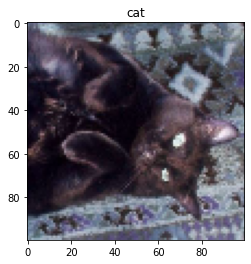

In [0]:
index=2
plt.imshow(x_train_data[index])
plt.title(name[int(y_train_data[index])])

In [0]:
print(x_train_data.shape,y_train_data.shape)

(25000, 100, 100, 3) (25000, 1)


In [0]:
# return the normalize data
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (50, 50, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

In [0]:
# normalize data
n_x_train_data = normalize(x_train_data)
n_x_test_final = normalize(x_test_final)

In [0]:
# split the traning data and testing data
x_train, x_test, y_train, y_test = train_test_split(n_x_train_data, y_train_data, test_size=0.33, random_state=42)

# Data Visualization

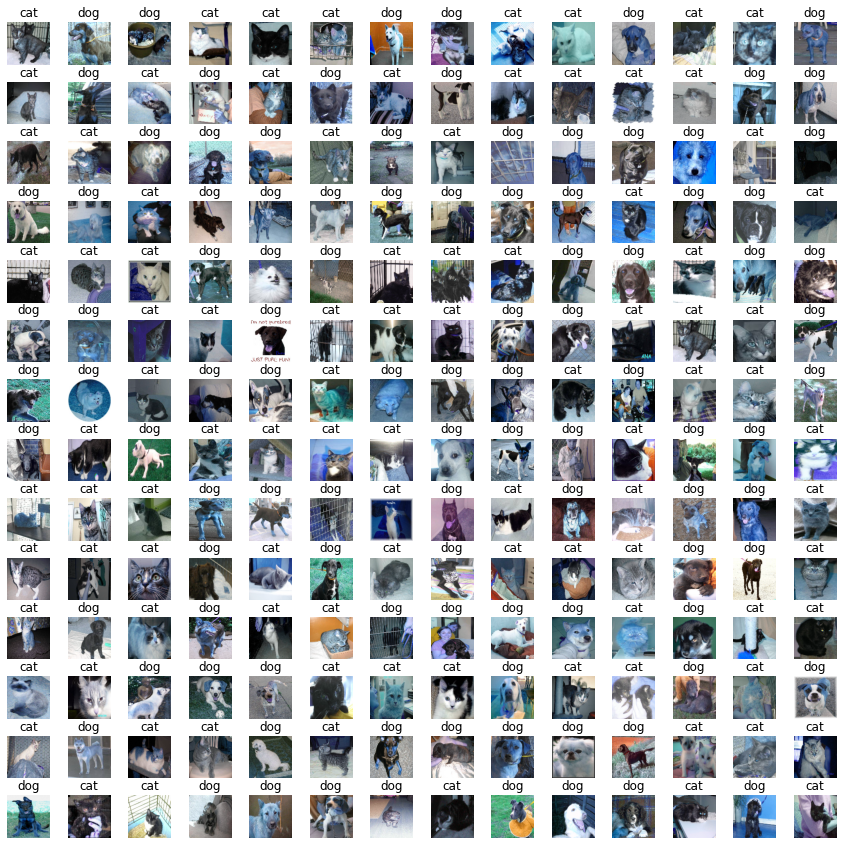

In [0]:
# show some image
W_grid = 14
L_grid = 14

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(x_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(x_train[index])
    axes[i].set_title(name[int(y_train[index])])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

# Create Cnn model

In [0]:
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	# Creating an object (Initilizing CNN)
  model = tf.keras.models.Sequential()
  # Adding first CCN layer
  # 1) filters (kernel/feature detectors) = 64
  # 2) kernal size = 3
  # 3) padding = same
  # 4) activation = ReLU
  # 5) input shape = (50, 50)

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=[IMG_SIZE, IMG_SIZE,3]))
  # Adding maxpool layer
  # 1) pool size = 2
  # 2) strides = 2
  # 3) padding = valid

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
  # adding second CNN layer and maxpool layer

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
  # Adding Flattening layer
  model.add(tf.keras.layers.Flatten())
  # Adding the dropout layer
  model.add(tf.keras.layers.Dropout(0.4))
  # Adding fully connected layer

  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  # Adding output layer

  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  # Compiling the model

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # model1.summary()
  return model

In [0]:
# learning curve based on history
def learning_curve(history, epoch):

  # training vs validation accuracy
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

  # training vs validation loss
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()


In [0]:
# predict uncalibrated probabilities
def uncalibrated(trainX, trainy,epoch,validation_split=0):
	# fit a model
	model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=10, verbose=1,validation_split=validation_split)
	history=model.fit(trainX, trainy)
	# model.save("model_uncalibrated_{}_epoch.h5".format(epoch))
	# plot_model(model, to_file='uncalibrated_model.png')
	return history,model
 


In [0]:
# predict calibrated probabilities
def calibrated(trainX,trainy,epoch,validation_split=0,cv=5):
	# define model
	model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=10, verbose=1,validation_split=validation_split)
	history=model.fit(trainX,trainy)
	# define and fit calibration model
	calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=cv)
	calibrated.fit(trainX,trainy)
 	# model.save_weights('model_calibrated_{}_epoch.h5'.format(epoch))
	# plot_model(model, to_file='calibrated_model.png')
	return history,model

# Model training

In [0]:
epochs=30

In [0]:
# uncalibrated model with 0.2 validation set
uncalibrated_history,uncalibrated_model=uncalibrated(x_train,y_train,epochs,0.2)

Train on 13400 samples, validate on 3350 samples
Epoch 1/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.6916 - accuracy: 0.5389 - val_loss: 0.6565 - val_accuracy: 0.6107
Epoch 2/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.6392 - accuracy: 0.6313 - val_loss: 0.5886 - val_accuracy: 0.6875
Epoch 3/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.5795 - accuracy: 0.6900 - val_loss: 0.5735 - val_accuracy: 0.6961
Epoch 4/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.5305 - accuracy: 0.7340 - val_loss: 0.5517 - val_accuracy: 0.7254
Epoch 5/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.4684 - accuracy: 0.7722 - val_loss: 0.5597 - val_accuracy: 0.7275
Epoch 6/30
13400/13400 [==============================] - 61s 5ms/sample - loss: 0.4037 - accuracy: 0.8106 - val_loss: 0.5528 - val_accuracy: 0.7191
Epoch 7/30
13400/13400 [==============================] -

In [0]:
# uncalibrated model with 0.2 validation set and cv=6
calibrated_history,calibrated_model=calibrated(x_train,y_train,epochs,0.2,4)

Train on 13400 samples, validate on 3350 samples
Epoch 1/30
13400/13400 [==============================] - 63s 5ms/sample - loss: 0.6922 - accuracy: 0.5343 - val_loss: 0.6722 - val_accuracy: 0.5725
Epoch 2/30
13400/13400 [==============================] - 62s 5ms/sample - loss: 0.6467 - accuracy: 0.6263 - val_loss: 0.6306 - val_accuracy: 0.6460
Epoch 3/30
13400/13400 [==============================] - 62s 5ms/sample - loss: 0.5904 - accuracy: 0.6863 - val_loss: 0.5742 - val_accuracy: 0.7027
Epoch 4/30
13400/13400 [==============================] - 63s 5ms/sample - loss: 0.5119 - accuracy: 0.7475 - val_loss: 0.5679 - val_accuracy: 0.7209
Epoch 5/30
13400/13400 [==============================] - 62s 5ms/sample - loss: 0.4378 - accuracy: 0.7952 - val_loss: 0.5400 - val_accuracy: 0.7424
Epoch 6/30
13400/13400 [==============================] - 63s 5ms/sample - loss: 0.3555 - accuracy: 0.8377 - val_loss: 0.6137 - val_accuracy: 0.7245
Epoch 7/30
13400/13400 [==============================] -

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 10049 samples, validate on 2513 samples
Epoch 1/30
10049/10049 [==============================] - 49s 5ms/sample - loss: 0.6916 - accuracy: 0.5288 - val_loss: 0.6846 - val_accuracy: 0.5392
Epoch 2/30
10049/10049 [==============================] - 48s 5ms/sample - loss: 0.6791 - accuracy: 0.5739 - val_loss: 0.6839 - val_accuracy: 0.5543
Epoch 3/30
10049/10049 [==============================] - 49s 5ms/sample - loss: 0.6622 - accuracy: 0.6030 - val_loss: 0.6422 - val_accuracy: 0.6303
Epoch 4/30
10049/10049 [==============================] - 51s 5ms/sample - loss: 0.6211 - accuracy: 0.6559 - val_loss: 0.6248 - val_accuracy: 0.6510
Epoch 5/30
10049/10049 [==============================] - 48s 5ms/sample - loss: 0.5605 - accuracy: 0.7073 - val_loss: 0.5809 - val_accuracy: 0.6968
Epoch 6/30
10049/10049 [==============================] - 49s 5ms/sample - loss: 0.4892 - accuracy: 0.7607 - val_loss: 0.5869 - val_accuracy: 0.7071
Epoch 7/30
10049/10049 [==============================] -

# Model visualization

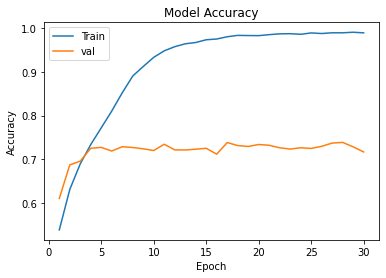

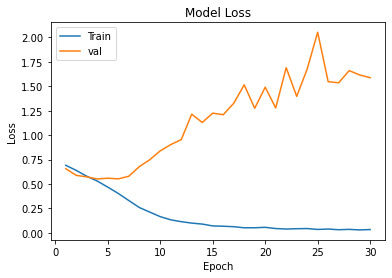

In [0]:
# plot the learning curve for uncalibrated data
learning_curve(uncalibrated_history, epochs)

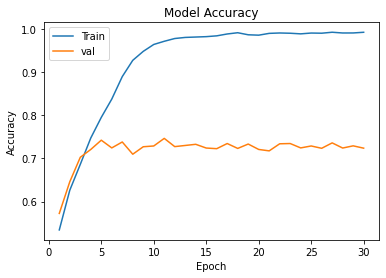

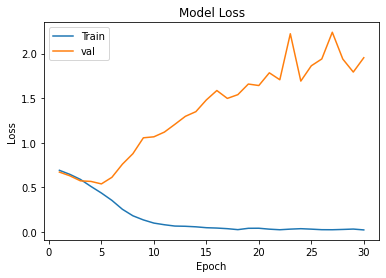

In [0]:
# plot the learning curve for calibrated data
learning_curve(calibrated_history, epochs)

# Model performance

8250/8250 [==============================] - 9s 1ms/sample
confusion matrix
[[2798 1340]
 [ 943 3169]]
final accuracy of unseen data: 0.7232727272727273
12500/12500 [==============================] - 12s 955us/sample


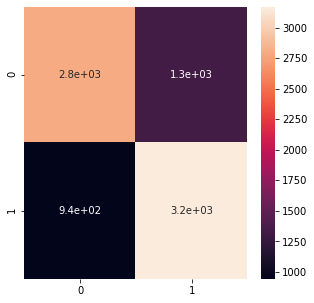

In [0]:
# Predictions of uncalibrated data
un_y_pred = uncalibrated_model.predict(x_test)
# Confusion matrix

from sklearn.metrics import confusion_matrix, accuracy_score
un_cm = confusion_matrix(y_test, un_y_pred)
print('confusion matrix')
print(un_cm)
plt.figure(figsize=(5,5))
sns.heatmap(un_cm,annot=True)
un_acc_cm = accuracy_score(y_test, un_y_pred)
print("final accuracy of unseen data:",un_acc_cm)
un_y_predict_final = uncalibrated_model.predict(x_test_final)

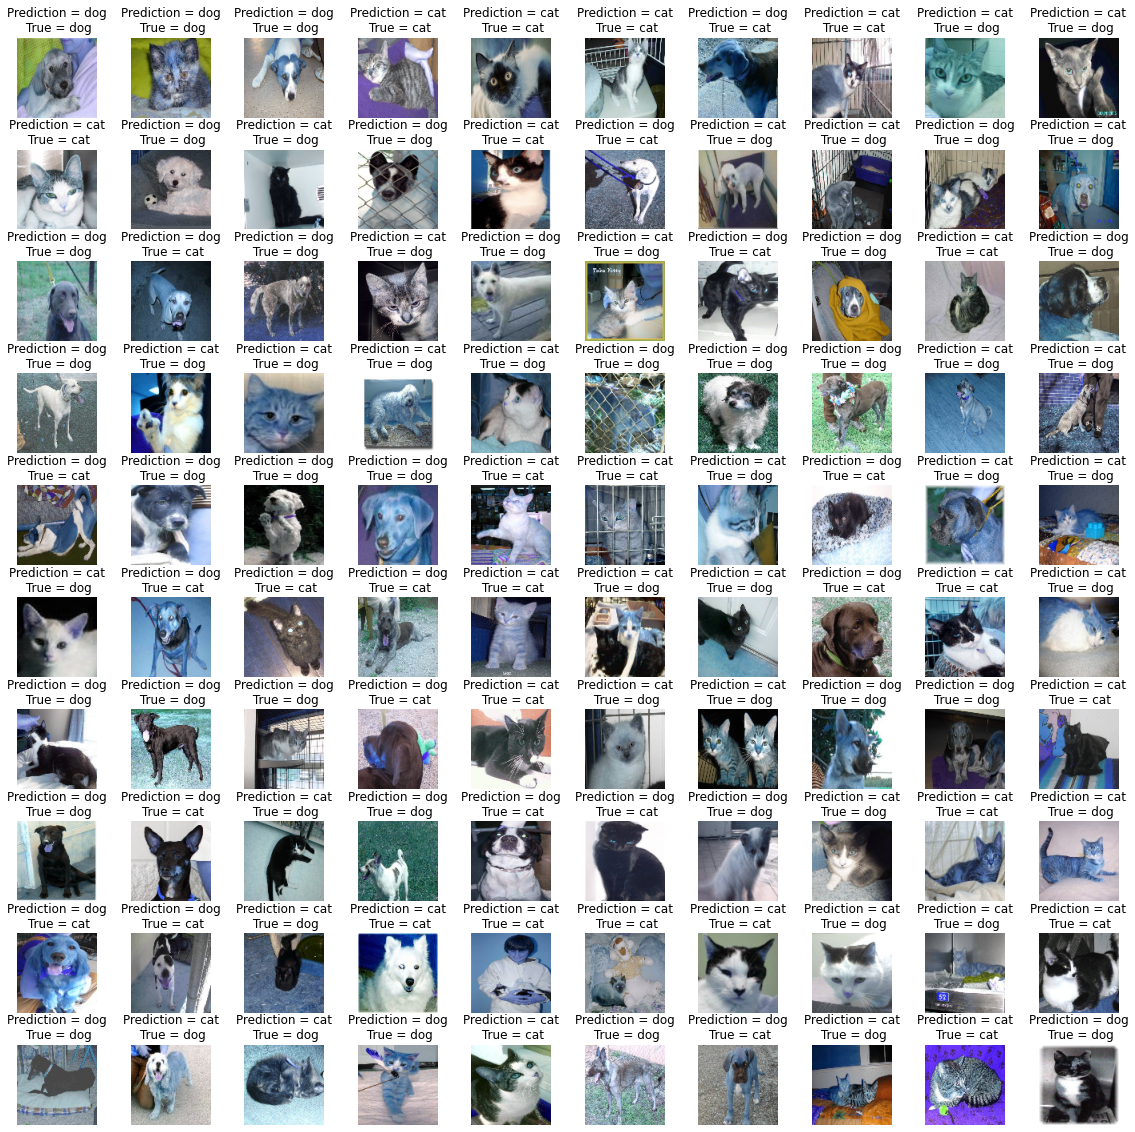

In [0]:
# show some images on there true value and predicted value
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (20, 20))
axes = axes.ravel()

n_training = len(x_test)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(x_test[index])
    axes[i].set_title('Prediction = {}\n True = {}'.format(name[int(un_y_pred[index])], name[int(y_test[i])]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

8250/8250 [==============================] - 8s 969us/sample
confusion matrix
[[2840 1298]
 [ 974 3138]]
final accuracy of unseen data: 0.7246060606060606
12500/12500 [==============================] - 12s 956us/sample


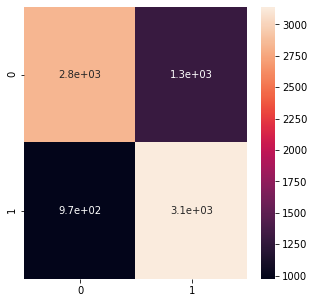

In [0]:
# Predictions of calibrated data
c_y_pred = calibrated_model.predict(x_test)
# Confusion matrix

from sklearn.metrics import confusion_matrix, accuracy_score
c_cm = confusion_matrix(y_test, c_y_pred)
print('confusion matrix')
print(c_cm)

# heat map of data
plt.figure(figsize=(5,5))
sns.heatmap(c_cm,annot=True)
c_acc_cm = accuracy_score(y_test, c_y_pred)

# print the accuracy of unseen data
print("final accuracy of unseen data:",c_acc_cm)
c_y_predict_final = calibrated_model.predict(x_test_final)

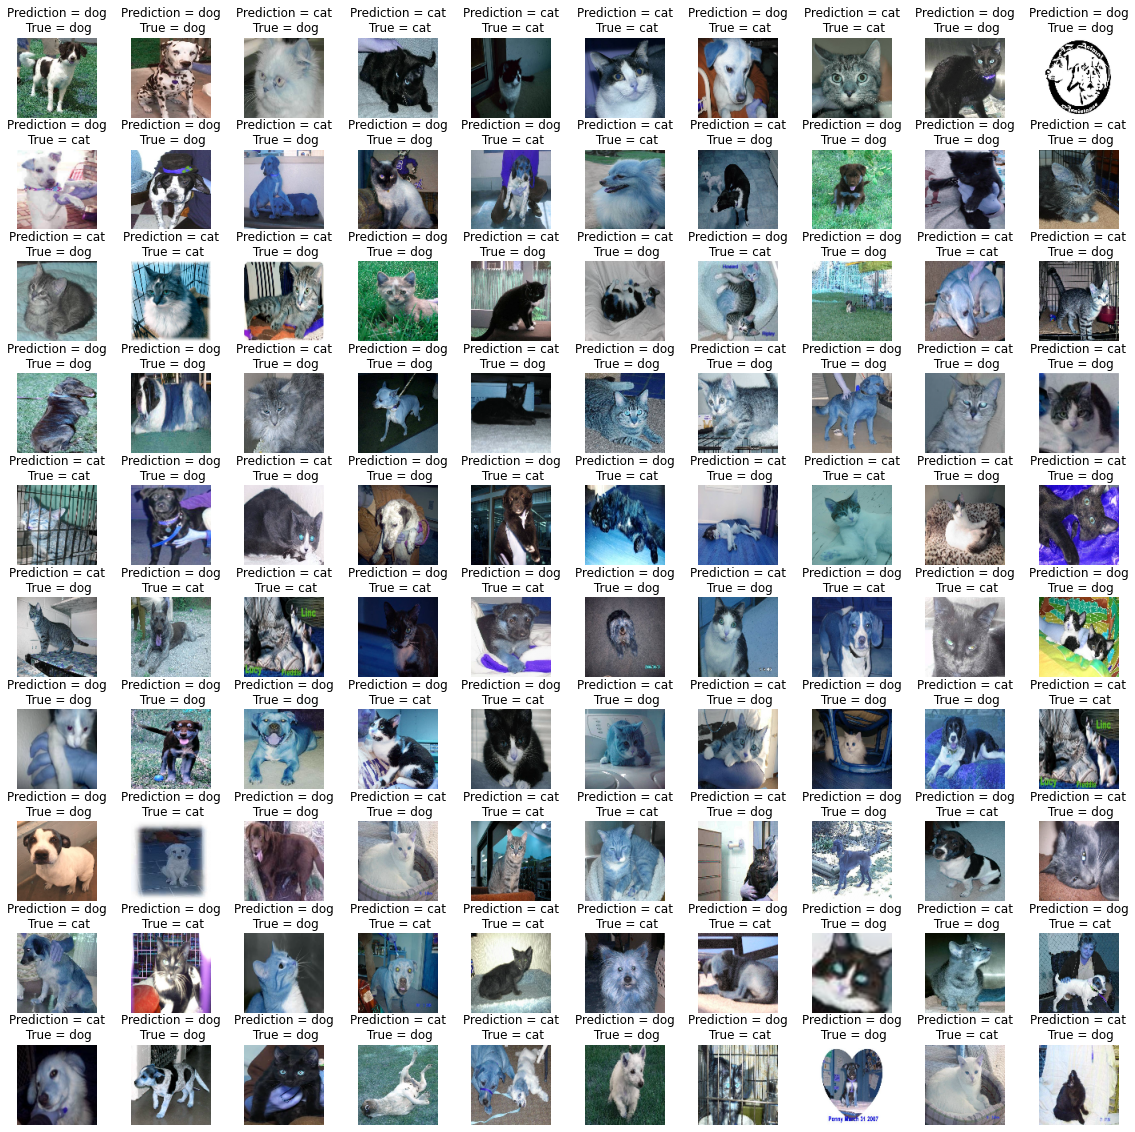

In [0]:
# show some images on there true value and predicted value
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (20, 20))
axes = axes.ravel()

n_training = len(x_test)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(x_test[index])
    axes[i].set_title('Prediction = {}\n True = {}'.format(name[int(c_y_pred[index])], name[int(y_test[i])]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)